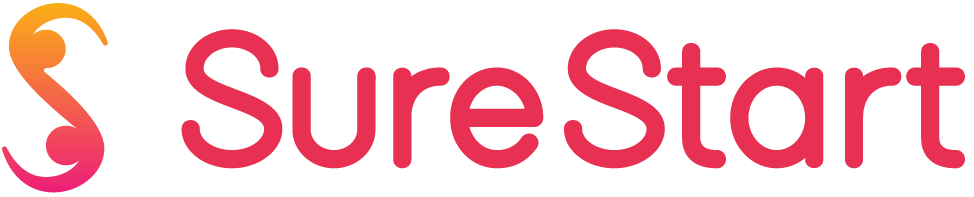

#Objective
* To acquaint you with the problem of overfit models and to mitigate it with regularization

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')

# Packages for modeling
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

root = Path('../content/')
input_path = root / 'input/'
ouput_path = root / 'output/'
source_path = root / 'source/'

def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])

    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = range(1, NB_START_EPOCHS + 1)

    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }

    metric_label = metrics_dict[metric]

    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

! gdown --id 1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u
! mkdir input/
! mv Tweets.csv input/

df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u
To: /content/Tweets.csv
100% 3.42M/3.42M [00:00<00:00, 50.7MB/s]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5594 - loss: 0.9866 - val_accuracy: 0.6426 - val_loss: 0.7440
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6871 - loss: 0.6874 - val_accuracy: 0.7473 - val_loss: 0.6009
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8023 - loss: 0.5211 - val_accuracy: 0.7944 - val_loss: 0.5354
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8570 - loss: 0.4164 - val_accuracy: 0.7944 - val_loss: 0.5142
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8794 - loss: 0.3454 - val_accuracy: 0.7959 - val_loss: 0.5131
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8995 - loss: 0.2933 - val_accuracy: 0.7967 - val_loss: 0.5248
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9180 - loss: 0.2461 - val_accuracy: 0.7906 - val_loss: 0.5515
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9278 - loss: 0.2130 - val_accuracy: 0.7898 - v

# Applying regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.


In [2]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 644,419 (2.46 MB)

 Trainable params: 644,419 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5790 - loss: 1.1692 - val_accuracy: 0.6320 - val_loss: 0.9063
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6594 - loss: 0.8540 - val_accuracy: 0.7322 - val_loss: 0.7589
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7810 - loss: 0.6923 - val_accuracy: 0.7777 - val_loss: 0.6723
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8398 - loss: 0.5824 - val_accuracy: 0.8035 - val_loss: 0.6350
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8635 - loss: 0.5054 - val_accuracy: 0.8042 - val_loss: 0.6243
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8836 - loss: 0.4552 - val_accuracy: 0.8065 - val_loss: 0.6219
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8955 - loss: 0.4179 - val_accuracy: 0.8027 - val_loss: 0.6304
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.3847 - val_accuracy: 0.7929 - v

For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterwards.



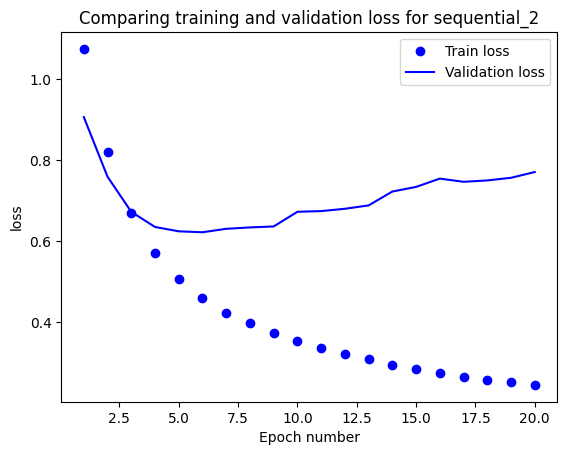

In [4]:
eval_metric(reg_model, reg_history, 'loss')

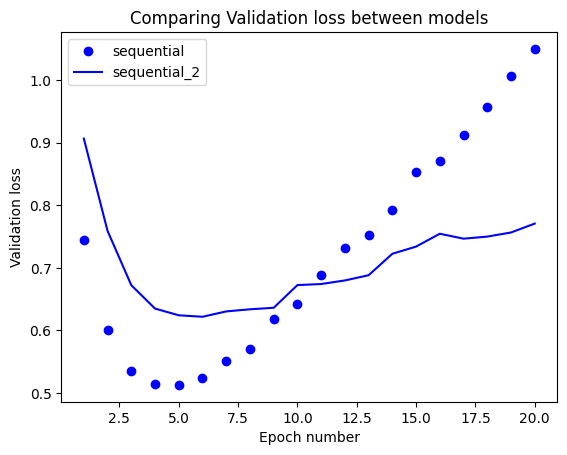

In [5]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

## Question 1

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 1

In [7]:
weights = [-5, 4, -3, 2, 1]
#l1 regularizer
def l1_norm(weights):
    reg= sum(abs(i) for i in weights)
    return reg

print(l1_norm(weights))

15


## Question 2

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||_2^2$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 2

In [8]:
weights = [-5, 4, -3, 2, 1]
#l2 regularizer
def l2_norm(weights):
    reg=sum(i**2 for i in weights)
    return reg

print(l2_norm(weights))

55


## Adding dropout layers
Add dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [9]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 644,419 (2.46 MB)

 Trainable params: 644,419 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5618 - loss: 0.9925 - val_accuracy: 0.6320 - val_loss: 0.7673
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6466 - loss: 0.7474 - val_accuracy: 0.6995 - val_loss: 0.6648
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7330 - loss: 0.6400 - val_accuracy: 0.7724 - val_loss: 0.5902
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7897 - loss: 0.5511 - val_accuracy: 0.7868 - val_loss: 0.5477
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.8228 - loss: 0.4836 - val_accuracy: 0.8005 - val_loss: 0.5255
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8449 - loss: 0.4411 - val_accuracy: 0.8020 - val_loss: 0.5200
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8644 - loss: 0.3919 - val_accuracy: 0.8020 - val_loss: 0.5180
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8748 - loss: 0.3609 - val_accuracy: 0.7997 -

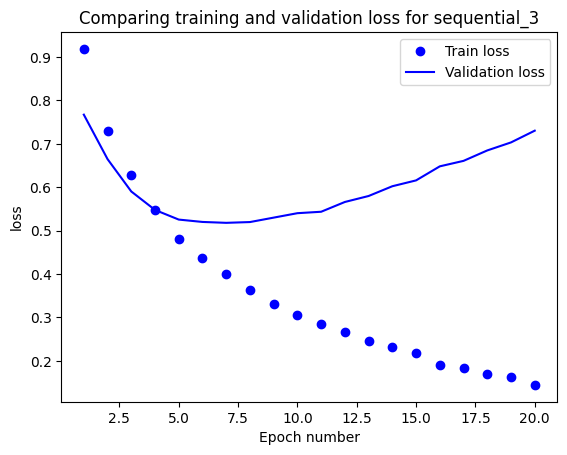

In [11]:
eval_metric(drop_model, drop_history, 'loss')


The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.



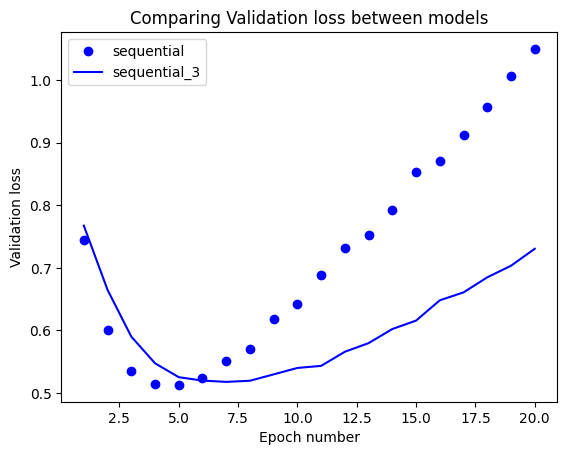

In [12]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')


The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.



## Combined L2 + dropout

In [13]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(NB_WORDS,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)
])


In [14]:
combined_history = deep_model(combined_model, X_train_rest, y_train_rest, X_valid, y_valid)
combined_min = optimal_epoch(combined_history)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.5632 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.6284 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.6201 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.6237 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step - accuracy: 0.6217 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.6280 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.6261 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6299 - loss: nan - val_accuracy: 0.6320 - val_loss: nan
Epoch 9/20
24/24 ━━

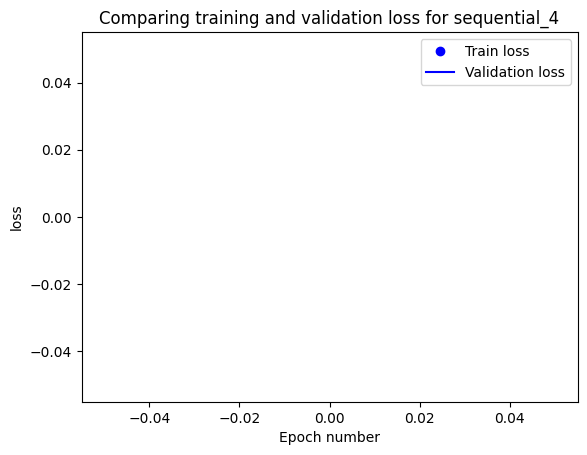

In [15]:
eval_metric(combined_model, combined_history, 'loss')


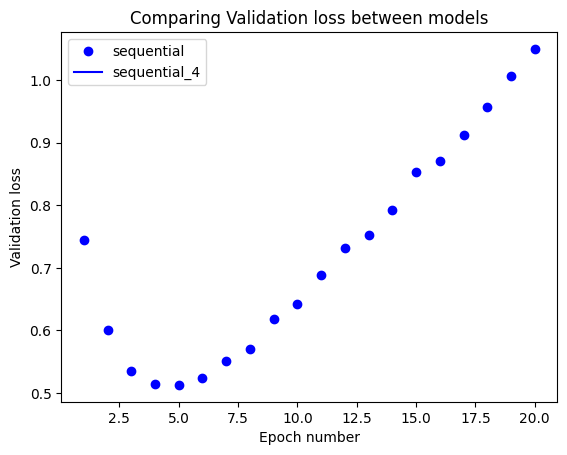

In [16]:
compare_models_by_metric(base_model, combined_model, base_history, combined_history, 'val_loss')


## Question 3

When does it make sense to add both L2 regularization and Dropout?

And what did doing so achieve in this case?


### Answer 3

\<*Dropout layers prevent overfitting and L2 regularization helps to keep the weights small, so we should add both when we want to have a more balanced and stable model.*\>

#Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [17]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9652 - loss: 0.1468
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9759 - loss: 0.0848
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9800 - loss: 0.0692
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9824 - loss: 0.0616
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9859 - loss: 0.0500
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - loss: 0.9881

Test accuracy: 77.39%


In [18]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)


Epoch 1/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9063 - loss: 0.2774
Epoch 2/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9118 - loss: 0.2652
Epoch 3/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9155 - loss: 0.2588
Epoch 4/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9154 - loss: 0.2571
Epoch 5/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9209 - loss: 0.2402
Epoch 6/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9266 - loss: 0.2292
Epoch 7/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9304 - loss: 0.2209
Epoch 8/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9286 - loss: 0.2211
Epoch 9/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9334 - loss: 0.2031
Epoch 10/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9350 - loss: 0.2043
Epoch 11/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9356 - loss: 0.2018
Epoch 12/14
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy:

In [19]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)


Epoch 1/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9492 - loss: 0.2845
Epoch 2/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9581 - loss: 0.2533
Epoch 3/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9585 - loss: 0.2417
Epoch 4/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9623 - loss: 0.2333
Epoch 5/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9661 - loss: 0.2230
Epoch 6/6
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9719 - loss: 0.2115
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7848 - loss: 0.7925

Test accuracy: 78.28%


In [20]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)


Epoch 1/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9408 - loss: 0.2020
Epoch 2/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1852
Epoch 3/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9504 - loss: 0.1667
Epoch 4/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9517 - loss: 0.1542
Epoch 5/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9565 - loss: 0.1376
Epoch 6/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9584 - loss: 0.1364
Epoch 7/7
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9605 - loss: 0.1272
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8049 - loss: 0.7923

Test accuracy: 79.51%


# Handling Underfitting
* In a general situation, the best strategy is to increase the model complexity by either increasing the number of parameters of your deep learning model or the order of your model. Underfitting is due to the model being simpler than needed. It fails to capture the patterns in the data. Increasing the model complexity will lead to improvement in training performance. If we use a large enough model it can even achieve a training error of zero i.e. the model will memorize the data and suffer from over-fitting. The goal is to hit the optimal sweet spot.
* Try to train the model for more epochs. Ensure that the loss is decreasing gradually over the course of the training. Otherwise, it is highly likely that there is some kind of bug or problem in the training code/logic itself.
* If you aren’t shuffling the data after every epoch, it can harm the model performance. Ensuring that you are shuffling the data is a good check to perform at this point.

#Conclusion
To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

here are the ways to prevent underfitting

* Get more training data.
* Increase the size or number of parameters in the model.
* Increase the complexity of the model.
* Increasing the training time, until cost function is minimised.


# Bonus content - Visualizing L2 regularization


In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

In [ ]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax


Let's create a toy data:

In [ ]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function**

In [ ]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus Question 1

Plot the same for L1 regularization

### Answer

In [ ]:
cost = #Enter your code here
l1_penalty = #Enter your code here
cost_plus_l2 = #Enter your code here

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l1_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L1 reg. $||w||_2^2$')
plot_contour(cost_plus_l1, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L1 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus Question 2
After looking at the visualization to what the L1 and L2 normalizations, how do they help while training?

\<*Type your answer here*\>

# Upload this Colab Notebook to your Github repository. Also add your *reflections* on today's learning in README.md